# Visual comparisons

This notebook is a simple visualization of the differences between two networks by combining tools available in this repository.

To execute this notebook, you can use the pypsa-earth environment

### 1. Initial setup

General imports

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
import pypsa
import pandas as pd
import geopandas as gpd
from pypsa.clustering.spatial import get_clustering_from_busmap
import numpy as np

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



#### Specify what networks to compare

In [2]:
# use_drive enables to download default data from gdrive
# When use_drive is true and the path of the file is not found,
# but it matches a value from dictionary file_ids,
# then the file is downloaded from gdrive
use_gdrive = True  

path_network_1 = "elec.nc"
# path_network_2 = "elec.nc"
gadm_shape = "gadm_shapes.geojson"

comparison_methodology = {
    "method": "shape",
    "options": {
        "path": "gadm_shapes.geojson"
    }
}  # method option among: ["country_shape", "gadm_shape", ...]
# TODO: expand to include network_1 and network_2; example: create voronoi polygons and compare them or alike,
# or "find_closest" to compare the closest nodes

# global crs parameters
GEO_CRS = "EPSG:4326"
METRIC_CRS = "EPSG:3857"

### 2. Cluster network

In [3]:
# Load networks
n1 = pypsa.Network(path_network_1)  # first network
# n2 = pypsa.Network(path_network_2)  # second network

# Utility function for dataframe to geodataframe conversion
def buses_to_geodf(df_buses, INPUT_CRS=GEO_CRS, OUTPUT_CRS=METRIC_CRS):
    """Function to transform a buses dataframe into a geodataframe with the correct crs."""
    return gpd.GeoDataFrame(
        df_buses,
        geometry=gpd.points_from_xy(df_buses.x, df_buses.y),
        crs=INPUT_CRS,
    ).to_crs(OUTPUT_CRS)


/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Applications/anaconda3/envs/pypsa-earth/li

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Sermisha_harddisk/01_OET/14_geothermal_modelling/geothermal-modelling/elec.nc'

### Create mapping of the networks for comparison purposes

##### Utility functions for mapping

In [ ]:
def shape_mapping(n, options):
    """Create mapping by shape"""
    gdf = gpd.read_file(options["path"])

    # create GADM_ID and country if missing (country_shapes.geojson)
    if "GADM_ID" not in gdf.columns:
        gdf["GADM_ID"] = gdf["name"]
    if "country" not in gdf.columns:
        gdf["country"] = gdf["name"]
    
    gdf.set_index("GADM_ID", inplace=True)
    df_mapped = n.buses.groupby("country").apply(
        lambda x: gpd.sjoin_nearest(buses_to_geodf(x), gdf[gdf.country==x.name].to_crs(METRIC_CRS), how="inner")
    ).droplevel(0, axis=0)
    return (df_mapped["index_right"] + " " + df_mapped.carrier).rename("mapping")


def create_bus_mapping(n, method):
    """Function to create the bus mapping of network n according to a given methodology"""
    match method["method"]:
        case "shape":
            return shape_mapping(n, method["options"])
        case _:
            raise NotImplementedError(f"Method {method['method']} not implemented")

In [19]:
aggregation_strategies = {
    "generators": {  # use "min" for more conservative assumptions
        "p_nom": "sum",
        "p_nom_max": "sum",
        "p_nom_min": "sum",
        "p_min_pu": "mean",
        "marginal_cost": "mean",
        "committable": "any",
        "ramp_limit_up": "max",
        "ramp_limit_down": "max",
        "efficiency": "mean",
    }
}

def get_aggregation_strategies(aggregation_strategies):
    """
    Default aggregation strategies that cannot be defined in .yaml format must
    be specified within the function, otherwise (when defaults are passed in
    the function's definition) they get lost when custom values are specified
    in the config.
    """
    import numpy as np

    # to handle the new version of PyPSA.
    try:
        from pypsa.clustering.spatial import _make_consense
    except Exception:
        # TODO: remove after new release and update minimum pypsa version
        from pypsa.clustering.spatial import _make_consense

    bus_strategies = dict(country=_make_consense("Bus", "country"))
    bus_strategies.update(aggregation_strategies.get("buses", {}))

    generator_strategies = {"build_year": lambda x: 0, "lifetime": lambda x: np.inf}
    generator_strategies.update(aggregation_strategies.get("generators", {}))

    return bus_strategies, generator_strategies

# Bus aggregation strategies

def create_clustering(n, busmap, aggregation_strategies=aggregation_strategies):
    # get aggregation strategies
    bus_strategies, generator_strategies = get_aggregation_strategies(aggregation_strategies)

    # get clustering
    clustering = get_clustering_from_busmap(
        n,
        busmap,
        bus_strategies=bus_strategies,
        aggregate_generators_weighted=True,
        aggregate_generators_carriers=None,
        aggregate_one_ports=["Load", "StorageUnit"],
        line_length_factor=1.0,
        generator_strategies=generator_strategies,
        scale_link_capital_costs=False,
    )
    return clustering.network, busmap

In [20]:
def create_clustered_network(n, method):
    return create_clustering(n, create_bus_mapping(n, method))

#### Execute the mapping

In [21]:
n1_mapped, n1_mapped_busmap = create_clustered_network(n1, comparison_methodology)
# n2_mapped, n2_mapped_busmap = create_clustered_network(n2, comparison_methodology)


C:\Users\Davide\AppData\Local\Temp\ipykernel_22000\1119178682.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_mapped = n.buses.groupby("country").apply(


AssertionError: In Bus cluster type the values of attribute type do not agree:
Line
12     Al/St 240/40 3-bundle 300.0
13     Al/St 240/40 3-bundle 300.0
133           243-AL1/39-ST1A 20.0
Name: type, dtype: object

### 3. Execute the comparison

#### General statistics by networks

In [ ]:
n1_mapped.buses

,v_nom,x,y,country,type,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network,generator
Bus,,,,,,,,,,,,,
AL AC,380.0,19.927367,41.531444,AL,,AC,,1.0,0.0,inf,Slack,0,AL AC offwind-ac
AT AC,380.0,14.865793,47.767081,AT,,AC,,1.0,0.0,inf,PQ,0,NaN
BA AC,380.0,18.074229,43.916493,BA,,AC,,1.0,0.0,inf,PQ,0,NaN
BE AC,380.0,4.751483,50.700642,BE,,AC,,1.0,0.0,inf,PQ,0,NaN
BG AC,380.0,25.701487,42.899809,BG,,AC,,1.0,0.0,inf,PQ,0,NaN
CH AC,380.0,8.069465,46.917252,CH,,AC,,1.0,0.0,inf,PQ,0,NaN
CZ AC,380.0,15.754442,49.730960,CZ,,AC,,1.0,0.0,inf,PQ,0,NaN
DE AC,380.0,9.665961,51.019035,DE,,AC,,1.0,0.0,inf,PQ,0,NaN
DK AC,380.0,10.741683,55.865331,DK,,AC,,1.0,0.0,inf,PQ,0,NaN


In [ ]:
s1 = n1_mapped.statistics()
s1

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           NaN                  0.0   
            Coal                              NaN                  0.0   
            Combined-Cycle Gas                NaN                  0.0   
            Lignite                           NaN                  0.0   
            Nuclear                           NaN                  0.0   
            Offshore Wind (AC)                NaN                  0.0   
            Offshore Wind (DC)                NaN                  0.0   
            Oil                               NaN                  0.0   
            Onshore Wind                      NaN                  0.0   
            Open-Cycle Gas                    NaN                  0.0   
            Run of River                      NaN                  0.0   
            Solar                             NaN                  0.0   
Line        -                                 NaN                  0.0   
Link        Dc                                NaN                  0.0   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              NaN                  0.0   
            Reservoir & Dam                   NaN                  0.0   

                                  Curtailment  Dispatch  Installed Capacity  \
            carrier                                                           
Generator   Biomass                       0.0       0.0        21288.691976   
            Coal                          0.0       0.0        63868.165361   
            Combined-Cycle Gas            0.0       0.0       184314.161000   
            Lignite                       0.0       0.0        45428.642753   
            Nuclear                       0.0       0.0       110054.100000   
            Offshore Wind (AC)            0.0       0.0         9571.078159   
            Offshore Wind (DC)            0.0       0.0        15421.868429   
            Oil                           0.0       0.0         5596.560390   
            Onshore Wind                  0.0       0.0       184646.174706   
            Open-Cycle Gas                0.0       0.0        13736.634932   
            Run of River                  0.0       0.0        49417.590917   
            Solar                         0.0       0.0       152969.743087   
Line        -                             NaN       NaN       267898.030457   
Link        Dc                            NaN       NaN        15440.000000   
Load        -                             NaN       0.0                 NaN   
StorageUnit Pumped Hydro Storage          0.0       0.0        54333.903000   
            Reservoir & Dam               0.0       0.0       101062.892434   

                                  Market Value  Operational Expenditure  \
            carrier                                                       
Generator   Biomass                        NaN                      0.0   
            Coal                           NaN                      0.0   
            Combined-Cycle Gas             NaN                      0.0   
            Lignite                        NaN                      0.0   
            Nuclear                        NaN                      0.0   
            Offshore Wind (AC)             NaN                      0.0   
            Offshore Wind (DC)             NaN                      0.0   
            Oil                            NaN                      0.0   
            Onshore Wind                   NaN                      0.0   
            Open-Cycle Gas                 NaN                      0.0   
            Run of River                   NaN                      0.0   
            Solar                          NaN                      0.0   
Line        -                              NaN                      NaN   


In [ ]:
# s2 = n2_mapped.statistics()
# s2

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           NaN                  0.0   
            Coal                              NaN                  0.0   
            Combined-Cycle Gas                NaN                  0.0   
            Geothermal                        NaN                  0.0   
            Lignite                           NaN                  0.0   
            Nuclear                           NaN                  0.0   
            Oil                               NaN                  0.0   
            Onshore Wind                      NaN                  0.0   
            Open-Cycle Gas                    NaN                  0.0   
            Run of River                      NaN                  0.0   
            Solar                             NaN                  0.0   
Line        AC                                NaN                  0.0   
Link        B2B                               NaN                  0.0   
            DC                                NaN                  0.0   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              NaN                  0.0   
            Reservoir & Dam                   NaN                  0.0   

                                  Curtailment  Dispatch  Installed Capacity  \
            carrier                                                           
Generator   Biomass                       0.0       0.0        10810.840000   
            Coal                          0.0       0.0       163391.398591   
            Combined-Cycle Gas            0.0       0.0       234797.503689   
            Geothermal                    0.0       0.0         1005.300000   
            Lignite                       0.0       0.0        89670.372561   
            Nuclear                       0.0       0.0       130904.482268   
            Oil                           0.0       0.0        49005.685117   
            Onshore Wind                  0.0       0.0       178176.160013   
            Open-Cycle Gas                0.0       0.0          242.699900   
            Run of River                  0.0       0.0        41411.276680   
            Solar                         0.0       0.0       151373.185408   
Line        AC                            NaN       NaN       771674.430195   
Link        B2B                           NaN       NaN        74000.000000   
            DC                            NaN       NaN       197937.680000   
Load        -                             NaN       0.0                 NaN   
StorageUnit Pumped Hydro Storage          0.0       0.0        51260.602320   
            Reservoir & Dam               0.0       0.0        81487.075478   

                                  Market Value  Operational Expenditure  \
            carrier                                                       
Generator   Biomass                        NaN                      0.0   
            Coal                           NaN                      0.0   
            Combined-Cycle Gas             NaN                      0.0   
            Geothermal                     NaN                      0.0   
            Lignite                        NaN                      0.0   
            Nuclear                        NaN                      0.0   
            Oil                            NaN                      0.0   
            Onshore Wind                   NaN                      0.0   
            Open-Cycle Gas                 NaN                      0.0   
            Run of River                   NaN                      0.0   
            Solar                          NaN                      0.0   
Line        AC                             NaN                      NaN   
Link        B2B                            NaN                      0.0   


Calculate percentage difference [\%]

In [ ]:
# delta_mapped = s2 - s1
# delta_mapped_pc = delta_mapped / s1 * 100
# delta_mapped_pc

Capacity Factor  Capital Expenditure  \
            carrier                                                      
Generator   Biomass                           NaN                  NaN   
            Coal                              NaN                  NaN   
            Combined-Cycle Gas                NaN                  NaN   
            Geothermal                        NaN                  NaN   
            Lignite                           NaN                  NaN   
            Nuclear                           NaN                  NaN   
            Offshore Wind (AC)                NaN                  NaN   
            Offshore Wind (DC)                NaN                  NaN   
            Oil                               NaN                  NaN   
            Onshore Wind                      NaN                  NaN   
            Open-Cycle Gas                    NaN                  NaN   
            Run of River                      NaN                  NaN   
            Solar                             NaN                  NaN   
Line        -                                 NaN                  NaN   
            AC                                NaN                  NaN   
Link        B2B                               NaN                  NaN   
            DC                                NaN                  NaN   
            Dc                                NaN                  NaN   
Load        -                                 NaN                  NaN   
StorageUnit Pumped Hydro Storage              NaN                  NaN   
            Reservoir & Dam                   NaN                  NaN   

                                  Curtailment  Dispatch  Installed Capacity  \
            carrier                                                           
Generator   Biomass                       NaN       NaN          -49.217923   
            Coal                          NaN       NaN          155.826041   
            Combined-Cycle Gas            NaN       NaN           27.389834   
            Geothermal                    NaN       NaN                 NaN   
            Lignite                       NaN       NaN           97.387303   
            Nuclear                       NaN       NaN           18.945575   
            Offshore Wind (AC)            NaN       NaN                 NaN   
            Offshore Wind (DC)            NaN       NaN                 NaN   
            Oil                           NaN       NaN          775.639352   
            Onshore Wind                  NaN       NaN           -3.504007   
            Open-Cycle Gas                NaN       NaN          -98.233192   
            Run of River                  NaN       NaN          -16.201345   
            Solar                         NaN       NaN           -1.043708   
Line        -                             NaN       NaN                 NaN   
            AC                            NaN       NaN                 NaN   
Link        B2B                           NaN       NaN                 NaN   
            DC                            NaN       NaN                 NaN   
            Dc                            NaN       NaN                 NaN   
Load        -                             NaN       NaN                 NaN   
StorageUnit Pumped Hydro Storage          NaN       NaN           -5.656322   
            Reservoir & Dam               NaN       NaN          -19.369935   

                                  Market Value  Operational Expenditure  \
            carrier                                                       
Generator   Biomass                        NaN                      NaN   
            Coal                           NaN                      NaN   
            Combined-Cycle Gas             NaN                      NaN   
            Geothermal                     NaN                      NaN   
            Lignite                        NaN                 

c:\Users\Davide\miniconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x1c6da161060>,
 <matplotlib.collections.LineCollection at 0x1c6da0f17e0>)

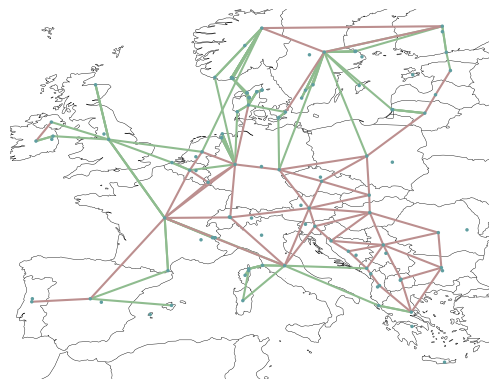

In [ ]:
n1.plot()

In [ ]:
n1_mapped.plot()

#### Compare lines

In [ ]:
# utility function
def add_line_names(lines):
    """Prepare line names for comparison"""
    lines["carrier"] = lines.bus0.str.split().str[1]
    lines["name"] = lines.bus0.str.split().str[0] + " - " + lines.bus1.str.split().str[0]

    return lines

Compare lines as dataframe

In [ ]:
# lines1 = add_line_names(n1_mapped.lines.copy()).set_index("name")
# lines2 = add_line_names(n2_mapped.lines.copy()).set_index("name")

# carrier = pd.concat([lines1.carrier, lines2.carrier[lines2.index.difference(lines1.index)]], ignore_index=False)

# delta_lines = pd.concat([carrier, lines1.s_nom.rename("lines 1"), lines2.s_nom.rename("lines 2")], axis=1).fillna(0)
# delta_lines["bus0"] = delta_lines.index.str.split(" - ").str[0] 
# delta_lines["bus1"] = delta_lines.index.str.split(" - ").str[1] 
# delta_lines["delta"] = delta_lines["lines 2"] - delta_lines["lines 1"]
# delta_lines["delta_pu"] = (delta_lines["delta"] / (delta_lines["lines 1"] + delta_lines["lines 2"]) * 2).fillna(0)
# delta_lines["delta_pc"] = delta_lines["delta_pu"] * 100

# header_cols = ["carrier", "bus0", "bus1", "lines 1", "lines 2", "delta", "delta_pu", "delta_pc"]
# delta_lines = delta_lines[header_cols]
# delta_lines

,carrier,bus0,bus1,lines 1,lines 2,delta,delta_pu,delta_pc
name,,,,,,,,
AL - GR,AC,AL,GR,1698.102612,4379.317262,2681.214650,0.882353,88.235294
AL - ME,AC,AL,ME,2189.658631,7775.522485,5585.863854,1.121076,112.107623
AL - MK,AC,AL,MK,0.000000,0.000000,0.000000,0.000000,0.000000
AL - RS,AC,AL,RS,2189.658631,0.000000,-2189.658631,-2.000000,-200.000000
AT - CH,AC,AT,CH,6792.410447,34869.196525,28076.786078,1.347849,134.784940
AT - CZ,AC,AT,CZ,4379.317262,8758.634524,4379.317262,0.666667,66.666667
AT - DE,AC,AT,DE,16042.600990,53847.727557,37805.126567,1.081841,108.184143
AT - HU,AC,AT,HU,4379.317262,11707.970639,7328.653377,0.911111,91.111111
AT - IT,AC,AT,IT,491.556019,3440.892134,2949.336115,1.500000,150.000000
